### Validating analytic workflows

In this notebook we will show how to use simulations and create synthetic data to validate an analysis workflow.



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC
from sklearn.metrics import balanced_accuracy_score, r2_score
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from nilearn.maskers import NiftiMasker
from nilearn.image import smooth_img, index_img, resample_to_img
from nilearn.glm import threshold_stats_img
from nilearn.datasets import (
    fetch_atlas_difumo,
    load_mni152_brain_mask,
    load_mni152_template
)
import nilearn.plotting
import nibabel as nib
from ipywidgets import IntProgress
from IPython.display import display


/Users/poldrack/anaconda3/envs/py39/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


### Generating synthetic neuroimaging data

It can be useful to benchmark analyses using synthetic data before ever applying them to real data.  In the best case, one would actually pre-register the analyses developed on synthetic data prior applying them to real data.

Let's say that we wanted to test a new "biomarker" for depression using task fMRI.  We could start by generating some random data (using the MNI305 mask as our starting point) and then apply our new technique to that, either using a completely random value for diagnostic category, or creating the diagnostic category to have a specific relationship to the synthetic brain data.

First, we can set up a [`NiftiMasker`](https://nilearn.github.io/stable/modules/generated/nilearn.maskers.NiftiMasker.html) based on the MNI305 mask:

In [2]:
mnimask = load_mni152_brain_mask(resolution=3.)
mnitemplate = load_mni152_template(resolution=3.)

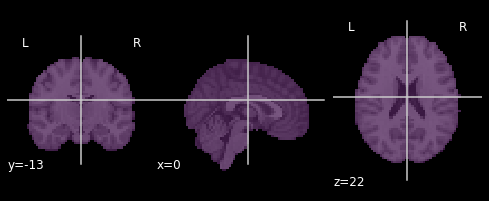

In [3]:
disp = nilearn.plotting.plot_anat(mnitemplate)
disp.add_overlay(mnimask, alpha=0.5)

In [4]:
masker = NiftiMasker()
maskdata = masker.fit_transform(mnimask)
maskdata.shape

(1, 69765)

We then generate random Gaussian data for each subject (let's say 100 subjects).


In [5]:
def generate_noise_img(maskimg, nsubs=100, seed=None, fwhm=8):
    masker = NiftiMasker()
    maskdata = masker.fit_transform(maskimg)
    
    rng = np.random.default_rng(seed)
    syndata = rng.normal(size=(nsubs, maskdata.shape[1]))
    synimg = masker.inverse_transform(syndata)
    if fwhm is not None:
        synimg = smooth_img(synimg, 8)
    return synimg, masker

synimg, masker = generate_noise_img(mnimask)

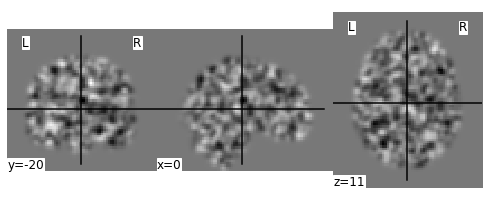

In [6]:
nilearn.plotting.plot_img(index_img(synimg, 1), cmap='gray')

### Testing our biomarker

Now let's test our biomarker.  Our innovation is to implement a feature selection procedure called "Select K best" to reduce the dimensionality of the data for the prediction model.  

In [7]:

def train_biomarker_model(img, y, mask, nfeatures=50, n_splits=20, 
                         seed=None, shuffle_y=False, fsel='outside'):
    # Validate parameters.
    assert fsel is None or fsel in ('inside', 'outside')
    assert y.shape[0] == img.shape[-1]

    # Extract masked data.
    masker = NiftiMasker(mask)
    maskdata = masker.fit_transform(img)
    
    # Shuffle y if requested.
    rng = np.random.RandomState(seed)
    if shuffle_y:
        y = y.copy()
        np.random.shuffle(y)

    # Select K best features from the entire dataset (outside of train/test split).
    if fsel == 'outside':
        selector = SelectKBest(f_classif, k=nfeatures)
        X = selector.fit_transform(maskdata, y)
    else:
        X = maskdata    

    clf = LinearSVC()
    scores = []
    for _ in range(n_splits):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rng)

        # Select K best features from the training set alone.
        if fsel == 'inside':
            selector = SelectKBest(f_classif, k=nfeatures)
            X_train = selector.fit_transform(X_train, y_train)
            X_test = selector.transform(X_test)

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        balanced_score = balanced_accuracy_score(y_test, y_pred)
        scores.append(balanced_score)
    return np.mean(scores)
    
rng = np.random.RandomState(1)
prevalence = 0.5
diag = (rng.uniform(size=synimg.shape[-1]) > prevalence).astype('int')

train_biomarker_model(synimg, diag, mnimask)


0.9553843378843376

If we didn't know that there was no true relationship between the brain data and diagnosis in this dataset, we wouldn't realize that this above-chance classification accuracy was weird. We would likely want to know whether the observed accuracy score is sufficiently larger than what one would expect under the null hypothesis of no predictive relationship (i.e. 50%). To determine this, we can run the model repeatedly while shuffling the order of the y variable, which essentially breaks the relationship on average between the X and y variables. In principle, this should have a balanced accuracy of 50%.

IntProgress(value=0, max=50)

0.9166781843285712


(array([ 1.,  0.,  0.,  6.,  8., 11., 10.,  8.,  5.,  1.]),
 array([0.830828  , 0.84535829, 0.85988859, 0.87441888, 0.88894918,
        0.90347947, 0.91800977, 0.93254007, 0.94707036, 0.96160066,
        0.97613095]),
 <BarContainer object of 10 artists>)

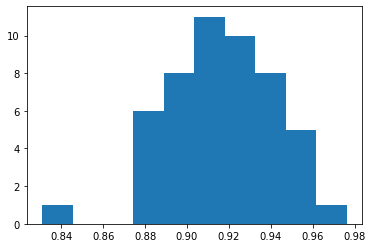

In [8]:
scores = []
nsimruns = 50

progbar = IntProgress(min=0, max=nsimruns) # instantiate the bar
display(progbar) # display the bar
for _ in range(nsimruns):
    progbar.value += 1
    scores.append(train_biomarker_model(synimg, diag, mnimask, shuffle_y=True))
print(np.mean(scores))
plt.hist(scores)

Wait, what? The accuracy scores are all well above 50% even when we shuffle the data, which means that there must be some kind of leaking of information from the test data into the training. In this case, it's due to the fact that our feature selection procedure was applied on the entire dataset prior to cross-validation, rather than within the cross-validation. If we move the feature selection step inside the cross-validation loop, we should see that the predictive accuracy decreases.

In [9]:
train_biomarker_model(synimg, diag, mnimask, fsel='inside')


0.4903339368964369

This example shows how injecting synthetic data into our analysis procedures can help ensure that they are not providing us with biased results.

### Generating realistic signals for testing

In the previous example we tested whether our procedure effectively controls for false positive results. In other cases, we may also want to know the degree to which our analysis procedure can accurately detect signals when they exist (often known as "parameter recovery"). To assess this, we need to generate synthetic data that contains both realistic signal and realistic noise, and then apply our procedure to assess its effectiveness.

Here we will inject some true signal relating activity to age into one of the regions of the brain, and then assess how well different methods can detect the signal.

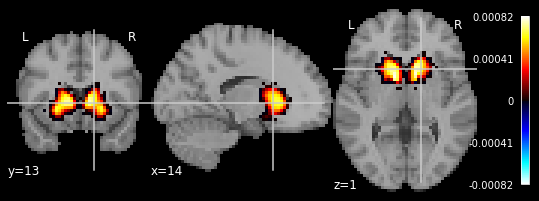

In [10]:
difumo = fetch_atlas_difumo(resolution_mm=2, legacy_format=False)
difumo_maps = nib.load(difumo['maps'])
# use component 63, which includes bilateral caudate
# first resample the difumo image to the same space as the data (which is the 3mm mni space)
roi_img = resample_to_img(index_img(difumo_maps, 63), mnitemplate)
disp = nilearn.plotting.plot_stat_map(roi_img, bg_img=mnitemplate)

Now let's generate some data by injecting signal into those masked voxels relating their activity to age.

Generate Gaussian noise, and then add signal within ROI voxels:



In [11]:
def generate_synthetic_data(roi_img, beta=10):
    synimg, masker = generate_noise_img(mnimask)
    syndata = masker.transform(synimg)
    roidata = np.repeat(masker.transform(roi_img), syndata.shape[0], 0)

    diag = rng.normal(size=syndata.shape[0]) > 0
    diagdata = np.repeat(diag[:, np.newaxis], roidata.shape[1], 1)

    return syndata + roidata * diagdata * beta, diag

simdata, diag = generate_synthetic_data(roi_img, beta=200)

Fit linear regression to confirm that signal injection worked:



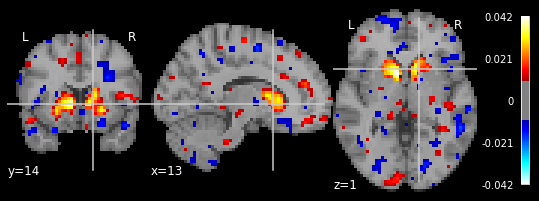

In [12]:
lr = LogisticRegression()
_ = lr.fit(simdata, diag)
coef_img = masker.inverse_transform(lr.coef_)
cut_coords = [13, 14, 1]
nilearn.plotting.plot_stat_map(coef_img, bg_img=mnitemplate, threshold=.01, cut_coords=cut_coords)

Let's say that we are interested in trying several different predictive methods to assess their ability to accurately estimate age in a new sample, and to identify the relevant voxels in the brain that support this prediction.

In [13]:
# try halving grid search to find optimal parameters

models = {
          'svm': LinearSVC(),
          'enet': SGDClassifier(penalty='elasticnet'),
         }
param_grid = {
    'svm': {
        'C': [0.1, 0.5, 1, 10, 25, 50, 100, 500, 1000, 10000]
    },   
    'enet': {
        'alpha': np.arange(0.1, 0.9, 0.2), 
        'l1_ratio': np.arange(0.1, 0.95, 0.2)
    },
}


def run_cv(simdata, diag, models, param_grid, seed=None, n_splits=20):

    scores = defaultdict(list)
    coefs = defaultdict(list)
    best_params = defaultdict(list)

    y = diag.copy()
        
    rng = np.random.RandomState(seed)

    for model, clf in models.items():
        print(f'Running {model}...')
        progbar = IntProgress(min=0, max=n_splits) # instantiate the bar
        display(progbar) # display the bar


        for _ in range(n_splits):
            progbar.value += 1
            X_train, X_test, y_train, y_test = train_test_split(
                simdata, y, test_size=0.25, random_state=rng
            )
            if model in param_grid:
                gsh = HalvingGridSearchCV(
                    estimator=clf, param_grid=param_grid[model], factor=2, random_state=rng
                )
                gsh.fit(X_train, y_train)
                clf.set_params(**gsh.best_params_)
                best_params[model].append(gsh.best_params_)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            scores[model].append(balanced_accuracy_score(y_test, y_pred))
            coefs[model].append(clf.coef_)
        mean_score = np.mean(scores[model])
        print(f'Mean r-squared for {model}: {mean_score}\n')

    return coefs, scores, best_params

In [14]:
coefs, scores, best_params = run_cv(simdata, diag, models, param_grid)

Running svm...


IntProgress(value=0, max=20)

Mean r-squared for svm: 0.6432197336976748

Running enet...


IntProgress(value=0, max=20)

Mean r-squared for enet: 0.7533631197234139



A simple way to look at the stability of the support for each classifier is to identify voxels with significant positive coefficient values across the cross-validation folds.

/var/folders/c4/hpq2bp2913j7jb77b6v5b7qh0000gn/T/ipykernel_4879/2641874704.py:11: RuntimeWarning: invalid value encountered in true_divide
  t[model] = np.nan_to_num(meancoef[model] / stderr)


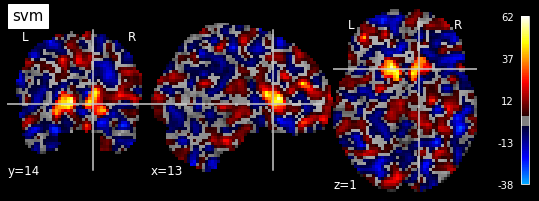

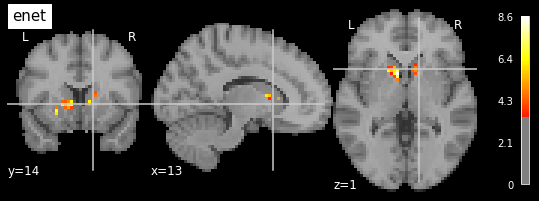

In [15]:
t_img = {}
t = {}
meancoef = {}

for model, coeflist in coefs.items():
    if coeflist == []:
        print('no coefs for', model)
        continue
    meancoef[model] = np.mean(coeflist, axis=0)
    stderr = np.std(coeflist, axis=0, ddof=1) / np.sqrt(len(coeflist))
    t[model] = np.nan_to_num(meancoef[model] / stderr)
    t_img[model] = masker.inverse_transform(t[model])
    t_img_thresh, threshold = threshold_stats_img(
        t_img[model], height_control='fdr', alpha=.01, cluster_threshold=20
    )
    # t_img[model].to_filename(f'{model}_tstat.nii.gz')
    nilearn.plotting.plot_stat_map(t_img_thresh, bg_img=mnitemplate, 
                                   cut_coords=cut_coords, threshold=threshold, 
                                   title=model, symmetric_cbar=False)

### Exercise

We would also like to check that there is no leakage in our cross-validation scheme, by testing the performance of the model when the outcome variable is shuffled. 

1. Modify the `run_cv()` function above to include a `shuffle_y` flag with a default value of `False`, and add code that will shuffle the y variable if this flag is set to true.  The following code should execute successfully if you have done this properly.


In [16]:
_, scores_shuf, _ = run_cv(simdata, diag, models, param_grid, shuffle_y=True)


TypeError: run_cv() got an unexpected keyword argument 'shuffle_y'

Use the `scores_shuf` output from the previous step to check whether the average accuracy value for each model falls between 0.475 and 0.525.

In [ ]:
for model in scores_shuf:
    ...